In [1]:
from six.moves import cPickle as pickle

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

import os as os
import fnmatch
import argparse
import pathlib
import time
import itertools

import numpy as np
if "DISPLAY" not in os.environ:
    mpl.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy.io as sio
import glob 

from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold  # k-fold cross validation StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler  # data normalization
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier  # random forest model
from sklearn.pipeline import Pipeline # model pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import make_scorer


%reload_ext autoreload

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')

plt.rcParams.update({'font.size': 22})
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2



In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
knownNames = glob.glob("../dataset/Dados_SONAR/*.mat")

X = [sio.loadmat(x)['ent_norm'] for x in knownNames]
Y = [(x.split('/')[-1][0]) for x in knownNames]

print(Y)

# Y = ['A' if y!='B' else y for y in Y]
# X2 = [sio.loadmat(x)['ent_norm'] for x in unknownNames]
# print(X)

minLengthVector = [np.shape(x)[0] for x in X]
minLengthKnown = int(np.min(minLengthVector))

# minLengthVector = [np.shape(x)[0] for x in X2]
# minLengthUnknown = int(np.min(minLengthVector))

minLength = minLengthKnown

le = LabelEncoder()
target = le.fit_transform(Y)

print(target)



# minLength = np.zeros(len(names))

# for i in range(len(names)):
#     x = sio.loadmat(str(names[i]))
#     y = x["ent_norm"]
#     minLength[i] = np.shape(y)[0]
# print(np.min(minLength))

['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'G', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'A', 'B', 'C', 'C', 'D', 'D', 'E', 'E', 'E', 'E', 'F', 'G', 'G', 'H', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'E', 'E', 'E', 'E', 'E', 'E', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D',

In [4]:
def increase_samples(data, wLength, ovSamples, label=None):
    
    y = []
    newLabel = []
    for counter, x in enumerate(data):
        size = np.shape(x)[0]
        beginWindowIndex = 0
        endWindowIndex = wLength
        if label is None:
            label2 = []
        else:    
            label2 = label[counter]
        
        while True:
            vector = np.reshape(x[beginWindowIndex:endWindowIndex,:], -1)
            y.append(vector)
            beginWindowIndex = beginWindowIndex + ovSamples
            endWindowIndex = endWindowIndex + ovSamples
            newLabel.append(label2)
            if endWindowIndex > size:
                break
            
    y = np.stack(y)
    return y, newLabel 

In [5]:
windowLength = 10
# xMatrixUnknown = np.stack([x[:minLength,:].reshape(-1) for x in X2])
# xMatrix2 = np.stack([x[:minLength,:].reshape(-1) for x in X2])


# print(xMatrix.shape)

# print(target.shape)
# # xMatrix = np.stack([x.reshape(-1) for x in X])


# # X_train, X_test, y_train, y_test = train_test_split(xMatrix, target, test_size=0.3, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

# print(X_train[0].shape)

# teste,label2 = increase_samples(X_train, 10, 1, y_train)


# # pca = PCA(10)
# # X_train = pca.fit_transform(X_train)
# # X_test = pca.fit_transform(X_test)

# model = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])
# # model = Pipeline([ ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])

# # model = Pipeline([('pca', PCA()), ('svm', svm.LinearSVC())])


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)


In [7]:
xMatrixTrainExtended,y_trainExtended = increase_samples(X_train, windowLength, 1, y_train)


In [8]:
model = Pipeline([('pca', PCA()), ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))])

In [9]:
xMatrixTest = np.stack([x[:windowLength,:].reshape(-1) for x in X_test])


In [10]:
fold = StratifiedKFold(10)


In [23]:
# parameters = {'pca__n_components': [252], 'rf__n_estimators': [82], 'rf__n_jobs': [-1],
#               'rf__min_samples_leaf': [35], 'rf__criterion': ['gini']}
metric = metrics.make_scorer(metrics.accuracy_score)
# metric = metrics.make_scorer(metrics.precision_score, average='weighted')



parameters = {'pca__n_components': sp_randint(10, 500), 'rf__n_estimators': sp_randint(10, 100), 'rf__n_jobs': [-1],
              'rf__min_samples_leaf': sp_randint(1, 100), 'rf__criterion': ['gini']}


# parameters = {'pca__n_components': sp_randint(10, 200)}

gridsearchcv = RandomizedSearchCV(model, parameters, scoring=metric, cv=fold, n_iter=10)

# print(xMatrixTrainExtended.shape)

# gridsearchcv = GridSearchCV(model, parameters, n_jobs=3, cv=fold, scoring=metric)
gridsearchcv.fit(xMatrixTrainExtended, y_trainExtended)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('rf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_node...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'pca__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f783c704510>, 'rf__criterion': ['gini'], 'rf__n_jobs': [-1], 'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f783c704dd0>, 'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7809eb2b10>},
          pre

In [24]:
gridsearchcv.cv_results_

{'mean_fit_time': array([ 14.99685414]),
 'mean_score_time': array([ 0.22479212]),
 'mean_test_score': array([ 0.87897955]),
 'mean_train_score': array([ 0.99256788]),
 'param_pca__n_components': masked_array(data = [288],
              mask = [False],
        fill_value = ?),
 'param_rf__criterion': masked_array(data = ['gini'],
              mask = [False],
        fill_value = ?),
 'param_rf__min_samples_leaf': masked_array(data = [54],
              mask = [False],
        fill_value = ?),
 'param_rf__n_estimators': masked_array(data = [98],
              mask = [False],
        fill_value = ?),
 'param_rf__n_jobs': masked_array(data = [-1],
              mask = [False],
        fill_value = ?),
 'params': [{'pca__n_components': 288,
   'rf__criterion': 'gini',
   'rf__min_samples_leaf': 54,
   'rf__n_estimators': 98,
   'rf__n_jobs': -1}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([ 0.89005786]),
 'split0_train_score': array([ 0.99267764]),
 'split1_

{'pca__n_components': 288, 'rf__n_jobs': -1, 'rf__criterion': 'gini', 'rf__n_estimators': 98, 'rf__min_samples_leaf': 54}
(array([ 0.87897955]), array([ 0.05871436]))
(0.88120433358528594, 0.88306018873562531, 0.89602984950635334)
Normalized confusion matrix
[[  6.94690265e-01   0.00000000e+00   6.78466077e-02   0.00000000e+00
    6.19469027e-02   2.94985251e-03   0.00000000e+00   1.72566372e-01]
 [  0.00000000e+00   7.79428571e-01   3.77142857e-02   0.00000000e+00
    1.14285714e-03   0.00000000e+00   1.20000000e-01   6.17142857e-02]
 [  4.66278102e-02   2.66444629e-02   8.02664446e-01   1.08243131e-02
    4.99583680e-03   0.00000000e+00   1.99833472e-02   8.82597835e-02]
 [  1.93423598e-03   0.00000000e+00   0.00000000e+00   9.36170213e-01
    1.16054159e-02   1.93423598e-02   0.00000000e+00   3.09477756e-02]
 [  4.18410042e-04   0.00000000e+00   1.21338912e-02   5.02092050e-03
    9.47698745e-01   1.67364017e-02   7.53138075e-03   1.04602510e-02]
 [  1.88492063e-02   6.94444444e-03 

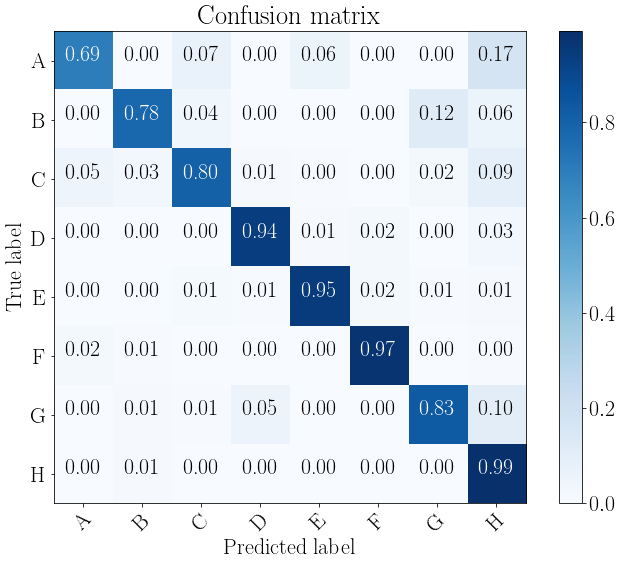

In [27]:
# best_n_components = gridsearchcv.best_params_['pca__n_components']

xMatrixTestExtended,y_testExtended = increase_samples(X_test, windowLength, 1, y_test)

print(gridsearchcv.best_params_)
means = gridsearchcv.cv_results_['mean_test_score']
stds = gridsearchcv.cv_results_['std_test_score']

print(means,stds)
acc = metrics.accuracy_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended))
F1 = metrics.f1_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended), average='weighted')
prec = metrics.precision_score(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended), average='weighted')
print(acc,F1,prec)

confusionMatrix = metrics.confusion_matrix(y_testExtended, gridsearchcv.best_estimator_.predict(xMatrixTestExtended))

plt.figure()
plot_confusion_matrix(confusionMatrix,normalize=True, classes=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
# print(np.max(resultsTest,axis=1))


In [22]:
dictionary = {'acc': acc, 'f1': F1, 'prec': prec, 'mean_test_score': means, 'std_test_score': stds, 
              'confMatrix': confusionMatrix, 'bestParams': gridsearchcv.best_params_}

sio.savemat('results_all_classes.mat', dictionary)

